In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import plotly.express as px
# set numpy seed
np.random.seed(42)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sktime.classification.kernel_based import RocketClassifier
from sktime.datasets import load_arrow_head  # Example dataset

from utils import filter_zero_min_players

In [2]:
# Load the combined data
csv_path = ('../datasets/black_dataframe/player_minutes_with_extra_columns_2425.csv')

df = pd.read_csv(csv_path)

In [3]:
df = filter_zero_min_players(df)

In [4]:
# Get number of players per team using groupby
team_counts = df.groupby('team')['player'].nunique().reset_index()

# Get the max value
max_players = team_counts['player'].max()

In [5]:
# Create an empty array to populate of shape (n, 38-TIME_SERIES_LENGTH, TIME_SERIES_LENGTH, N_PLAYERS)
N_PLAYERS = max_players # Max number of players for a team
TIME_SERIES_LENGTH = 7 # Number of previous weeks + current week

all_data_arr = np.zeros((len(df.team.unique()), 39-TIME_SERIES_LENGTH, TIME_SERIES_LENGTH, N_PLAYERS))

TEAMS = df.team.unique()

for i, team in enumerate(TEAMS):
    team_data = df[df['team'] == team]
    PLAYERS = team_data['player'].unique()

    for j, player in enumerate(PLAYERS):

        # Get the data for the specific team and player
        player_data = df[(df['team'] == team) & (df['player'] == player)]

        # Sort by week and reset index
        player_data = player_data.sort_values('week').reset_index(drop=True)

        # Extract the minutes played
        minutes_played = player_data['minutes'].to_numpy()

        # Split into chunks of 6 weeks
        for k in range(0, len(minutes_played) - TIME_SERIES_LENGTH + 1):
            chunk = minutes_played[k:k + TIME_SERIES_LENGTH]
            if len(chunk) == TIME_SERIES_LENGTH:
                all_data_arr[i, k, :, j] = chunk

In [6]:
# Flatten the first dimension of all_data_arr
all_data_arr = all_data_arr.reshape(-1, all_data_arr.shape[2])

In [7]:
X = all_data_arr[:, :-1]  # All but the last week
y = all_data_arr[:, -1]   # The last week

In [8]:
# Turn y into a multiclass classification problem with 3 classes: 0, 1-60, 61-90
y_dig = y.copy()
y_dig[y_dig < 1] = 0
y_dig[(y_dig >= 1) & (y_dig <= 60)] = 1
y_dig[y_dig > 60] = 2

/var/folders/rc/594kgpld1czfpr55m3_m1szw0000gr/T/ipykernel_67571/2848956793.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_dig, palette='viridis')


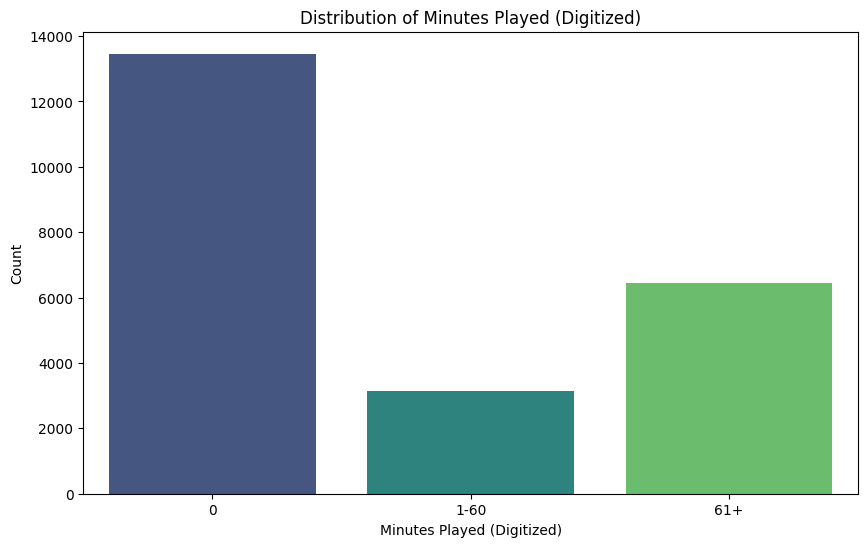

In [9]:
# Plot the distribution of y_dig
plt.figure(figsize=(10, 6))
sns.countplot(x=y_dig, palette='viridis')
plt.title('Distribution of Minutes Played (Digitized)')
plt.xlabel('Minutes Played (Digitized)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['0', '1-60', '61+'])
plt.show()

In [10]:
# Turn y_dig into integers
y_dig = y_dig.astype(int)

In [11]:
# Split the dataset into training and testing sets with 80% training and 20% testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_dig, test_size=0.2, random_state=42)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


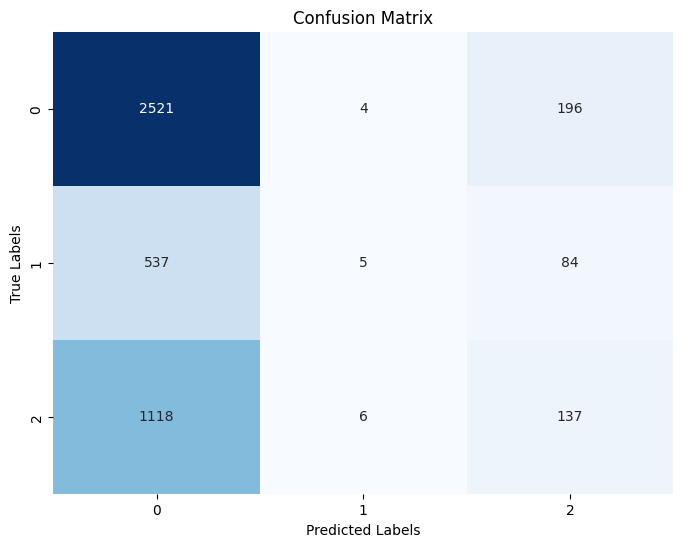

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.93      0.73      2721
           1       0.33      0.01      0.02       626
           2       0.33      0.11      0.16      1261

    accuracy                           0.58      4608
   macro avg       0.42      0.35      0.30      4608
weighted avg       0.49      0.58      0.48      4608



In [12]:
# Create and fit the ROCKET classifier
clf = RocketClassifier(num_kernels=500)
clf.fit(X_train, y_train)

# Generate predictions on the test set
y_pred = clf.predict(X_test)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Create a classification report
class_report = classification_report(y_test, y_pred)

# Print the classification report
print("Classification Report:\n", class_report)